<a href="https://colab.research.google.com/github/AnaBarb0sa/serie-temporal-M11/blob/main/predicao_serie_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de Série Temporal: Comparação entre Prophet e LSTM

Este notebook apresenta uma análise comparativa entre dois métodos de predição de séries temporais:
1. **Prophet** - Método desenvolvido pelo Facebook para séries temporais (Taylor & Letham, 2018)
2. **LSTM** - Rede Neural Recorrente para modelagem temporal (Hochreiter & Schmidhuber, 1997)

## Dataset Utilizado
**Daily Climate time series data** - Kaggle
- Link: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
- Descrição: Dados climáticos diários incluindo temperatura média, umidade, velocidade do vento e pressão atmosférica
- Período: 2013-2017
- Variável alvo: Temperatura média (meantemp)


## 1. Importação de Bibliotecas e Dados


In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

# TensorFlow/Keras para LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Configuração do matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas importadas com sucesso!")
print(f"TensorFlow versão: {tf.__version__}")


Bibliotecas importadas com sucesso!
TensorFlow versão: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carregando o dataset
df = pd.read_csv('/content/drive/MyDrive/M11/serie-temporal/DailyDelhiClimateTrain.csv')

# Convertendo a coluna de data para datetime
df['date'] = pd.to_datetime(df['date'])

# Renomeando as colunas para manter consistência com o código
df = df.rename(columns={
    'meantemp': 'meantemp',
    'humidity': 'humidity',
    'wind_speed': 'wind_speed',
    'meanpressure': 'meanpressure'
})

print("✅ Dataset real carregado com sucesso!")
print(f"Shape dos dados: {df.shape}")
print(f"Período: {df['date'].min()} até {df['date'].max()}")
print("\nPrimeiras 5 linhas:")
print(df.head())

print("\nInformações sobre o dataset:")
print(f"- Total de observações: {len(df)}")
print(f"- Variáveis: {list(df.columns)}")
print(f"- Valores nulos: {df.isnull().sum().sum()}")

# Verificando se há valores nulos e tratando se necessário
if df.isnull().sum().sum() > 0:
    print(f"\n⚠️  Encontrados {df.isnull().sum().sum()} valores nulos")
    print("Valores nulos por coluna:")
    print(df.isnull().sum())
    print("\nPreenchendo valores nulos com interpolação...")
    df = df.interpolate(method='linear')
    print("✅ Valores nulos tratados com sucesso!")
else:
    print("\n✅ Nenhum valor nulo encontrado!")


✅ Dataset real carregado com sucesso!
Shape dos dados: (1462, 5)
Período: 2013-01-01 00:00:00 até 2017-01-01 00:00:00

Primeiras 5 linhas:
        date   meantemp   humidity  wind_speed  meanpressure
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000

Informações sobre o dataset:
- Total de observações: 1462
- Variáveis: ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']
- Valores nulos: 0

✅ Nenhum valor nulo encontrado!


## 2. Análise Exploratória dos Dados


Informações básicas dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB
None

Estatísticas descritivas:
                      date     meantemp     humidity   wind_speed  \
count                 1462  1462.000000  1462.000000  1462.000000   
mean   2015-01-01 12:00:00    25.495521    60.771702     6.802209   
min    2013-01-01 00:00:00     6.000000    13.428571     0.000000   
25%    2014-01-01 06:00:00    18.857143    50.375000     3.475000   
50%    2015-01-01 12:00:00    27.714286    62.625000     6.221667   
75%    

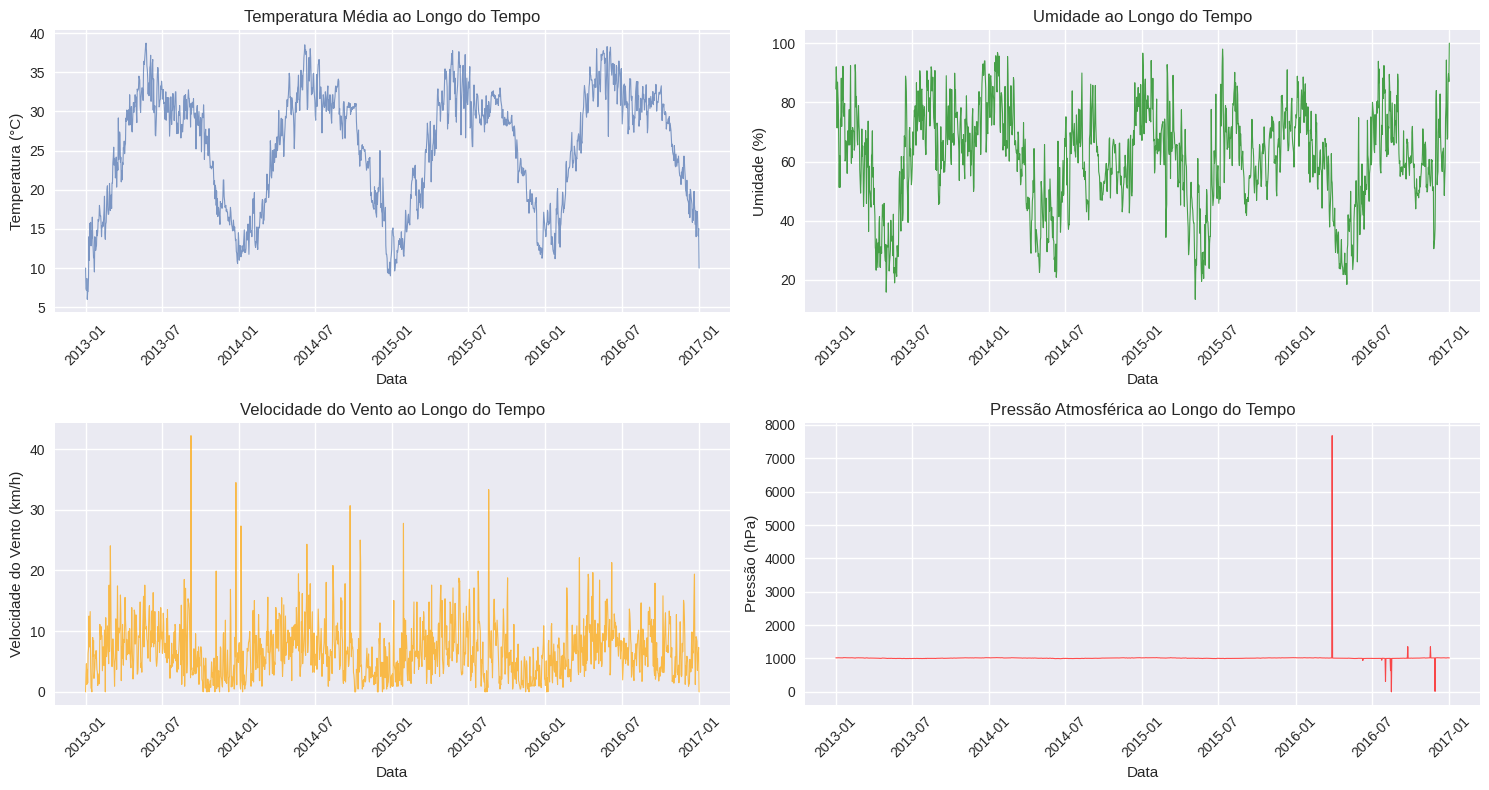

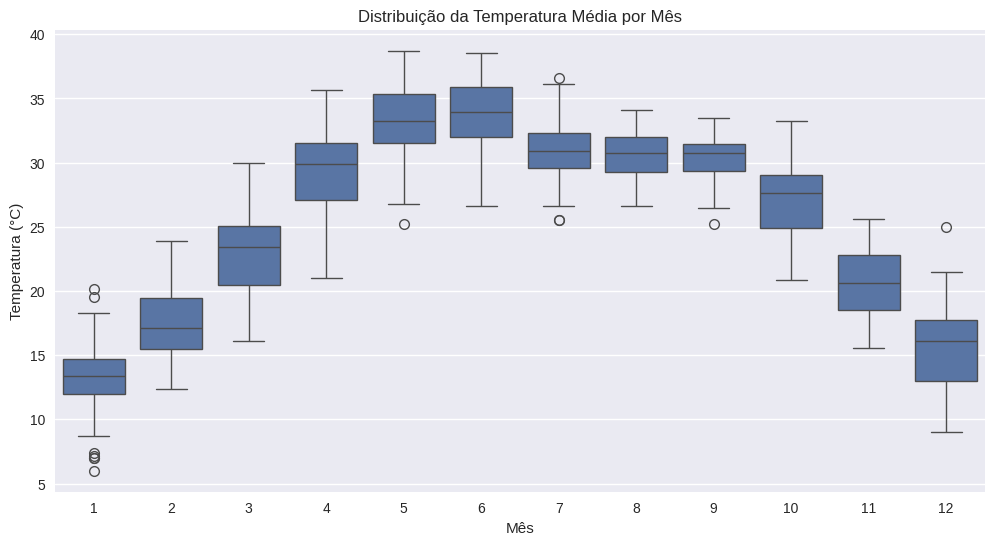

In [ ]:
# Análise exploratória dos dados
print("Informações básicas dos dados:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())

# Visualização da série temporal principal
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(df['date'], df['meantemp'], linewidth=0.8, alpha=0.7)
plt.title('Temperatura Média ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(df['date'], df['humidity'], linewidth=0.8, alpha=0.7, color='green')
plt.title('Umidade ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Umidade (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.plot(df['date'], df['wind_speed'], linewidth=0.8, alpha=0.7, color='orange')
plt.title('Velocidade do Vento ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Velocidade do Vento (km/h)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.plot(df['date'], df['meanpressure'], linewidth=0.8, alpha=0.7, color='red')
plt.title('Pressão Atmosférica ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Pressão (hPa)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Verificando sazonalidade
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Boxplot da temperatura por mês
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='meantemp')
plt.title('Distribuição da Temperatura Média por Mês')
plt.xlabel('Mês')
plt.ylabel('Temperatura (°C)')
plt.show()


## 3. Preparação dos Dados


In [ ]:
# Preparação dos dados para os modelos
# Divisão em treino e teste (últimos 365 dias para teste)
split_date = df['date'].max() - pd.Timedelta(days=365)
train_data = df[df['date'] <= split_date].copy()
test_data = df[df['date'] > split_date].copy()

print(f"Dados de treino: {len(train_data)} observações")
print(f"Dados de teste: {len(test_data)} observações")
print(f"Data de divisão: {split_date}")

# Preparação dos dados para Prophet
prophet_data = train_data[['date', 'meantemp']].copy()
prophet_data.columns = ['ds', 'y']

print("\nDados preparados para Prophet:")
print(prophet_data.head())

# Preparação dos dados para LSTM
lstm_data = train_data['meantemp'].values.reshape(-1, 1)
test_lstm_data = test_data['meantemp'].values.reshape(-1, 1)

# Normalização para LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data_scaled = scaler.fit_transform(lstm_data)
test_lstm_data_scaled = scaler.transform(test_lstm_data)

print(f"\nDados normalizados para LSTM:")
print(f"Shape dos dados de treino: {lstm_data_scaled.shape}")
print(f"Shape dos dados de teste: {test_lstm_data_scaled.shape}")
print(f"Min: {lstm_data_scaled.min():.4f}, Max: {lstm_data_scaled.max():.4f}")


Dados de treino: 1097 observações
Dados de teste: 365 observações
Data de divisão: 2016-01-02 00:00:00

Dados preparados para Prophet:
          ds          y
0 2013-01-01  10.000000
1 2013-01-02   7.400000
2 2013-01-03   7.166667
3 2013-01-04   8.666667
4 2013-01-05   6.000000

Dados normalizados para LSTM:
Shape dos dados de treino: (1097, 1)
Shape dos dados de teste: (365, 1)
Min: 0.0000, Max: 1.0000


## 4. Modelo Prophet


Treinando modelo Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpls8lulie/57yttvjr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpls8lulie/csrh3hkr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52493', 'data', 'file=/tmp/tmpls8lulie/57yttvjr.json', 'init=/tmp/tmpls8lulie/csrh3hkr.json', 'output', 'file=/tmp/tmpls8lulie/prophet_modelh67k9t57/prophet_model-20251005193009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:30:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Modelo Prophet treinado com sucesso!
Previsões geradas para 1462 períodos


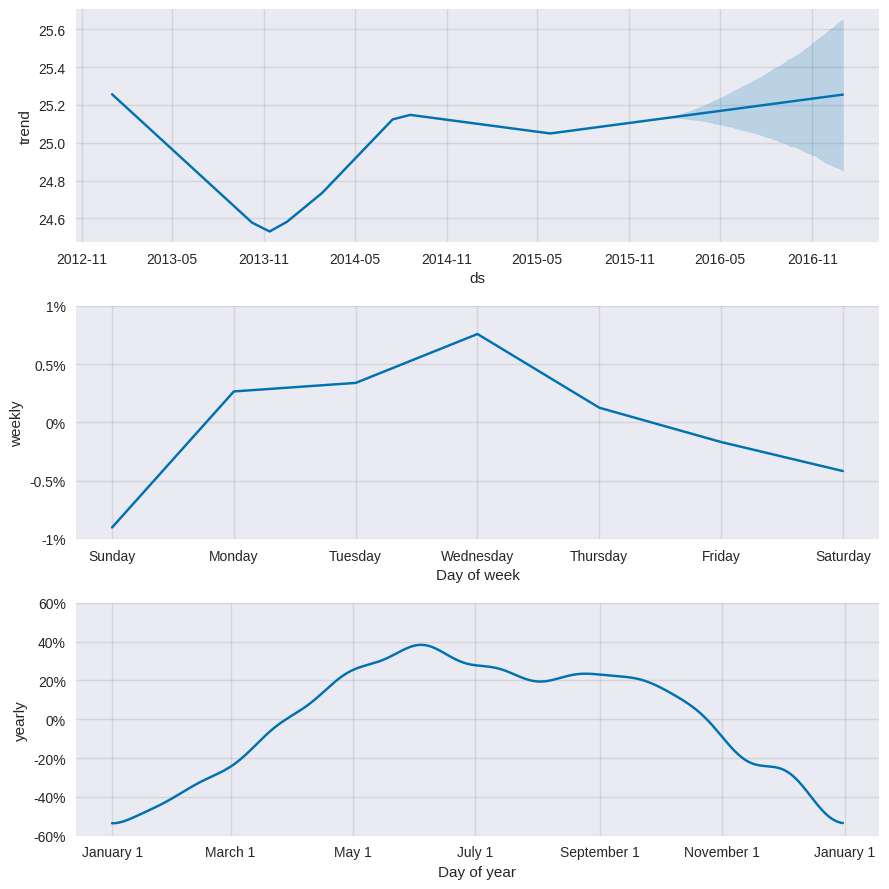

In [ ]:
# Treinamento do modelo Prophet
print("Treinando modelo Prophet...")

# Criando e configurando o modelo Prophet
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# Treinando o modelo
model_prophet.fit(prophet_data)

# Criando dataframe para previsões futuras (incluindo período de teste)
future = model_prophet.make_future_dataframe(periods=len(test_data), freq='D')

# Fazendo previsões
forecast_prophet = model_prophet.predict(future)

print("Modelo Prophet treinado com sucesso!")
print(f"Previsões geradas para {len(forecast_prophet)} períodos")

# Visualizando componentes do modelo
fig = model_prophet.plot_components(forecast_prophet)
plt.show()


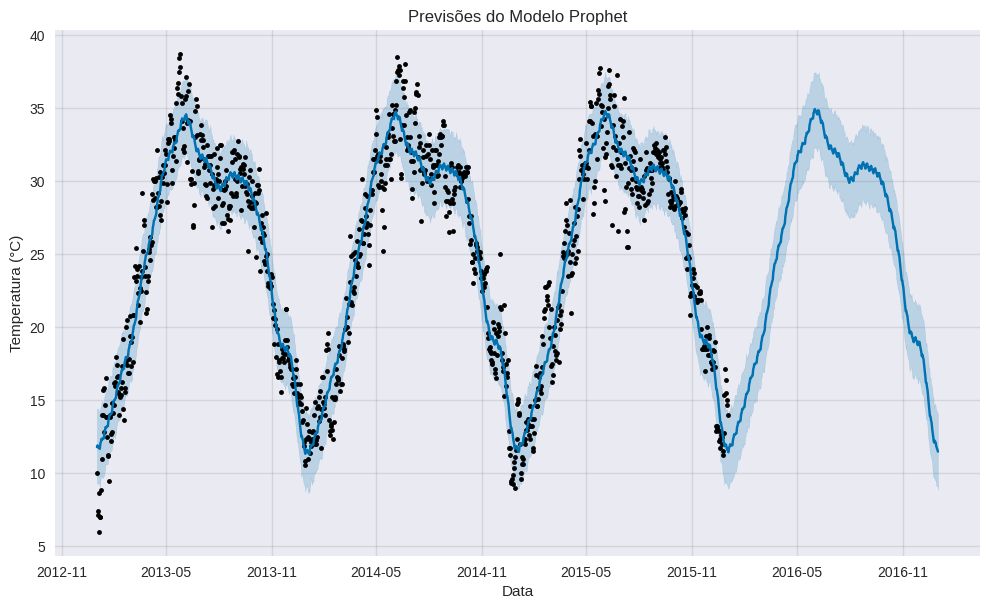

Previsões Prophet para período de teste:
Shape: (365,)
Primeiras 5 previsões: [11.44273232 11.76338286 11.82613731 11.99118621 11.90511106]
Valores reais (primeiros 5): [14.375      15.75       15.83333333 17.375      17.125     ]


In [ ]:
# Visualizando resultados do Prophet
fig = model_prophet.plot(forecast_prophet)
plt.title('Previsões do Modelo Prophet')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.show()

# Extraindo previsões para o período de teste
prophet_predictions = forecast_prophet['yhat'].tail(len(test_data)).values
prophet_lower = forecast_prophet['yhat_lower'].tail(len(test_data)).values
prophet_upper = forecast_prophet['yhat_upper'].tail(len(test_data)).values

print(f"Previsões Prophet para período de teste:")
print(f"Shape: {prophet_predictions.shape}")
print(f"Primeiras 5 previsões: {prophet_predictions[:5]}")
print(f"Valores reais (primeiros 5): {test_data['meantemp'].head().values}")


## 5. Modelo LSTM


In [ ]:
# Preparação dos dados para LSTM
def create_sequences(data, seq_length):
    """
    Cria sequências para treinamento do LSTM
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Definindo parâmetros
sequence_length = 60  # Usar 60 dias anteriores para prever o próximo dia

# Criando sequências de treino
X_train, y_train = create_sequences(lstm_data_scaled, sequence_length)

print(f"Dados de treino LSTM:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Reshape para LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print(f"X_train reshape: {X_train.shape}")
print(f"y_train reshape: {y_train.shape}")


Dados de treino LSTM:
X_train shape: (1037, 60)
y_train shape: (1037,)
X_train reshape: (1037, 60, 1)
y_train reshape: (1037,)


In [ ]:
# Construção do modelo LSTM
print("Construindo modelo LSTM...")

model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compilação do modelo
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Visualizando arquitetura do modelo
print("Arquitetura do modelo LSTM:")
model_lstm.summary()

# Treinamento do modelo
print("\nTreinando modelo LSTM...")
history = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False
)

print("Modelo LSTM treinado com sucesso!")


Construindo modelo LSTM...
Arquitetura do modelo LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)


Treinando modelo LSTM...
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.1178 - mae: 0.2909 - val_loss: 0.0247 - val_mae: 0.1353
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0200 - mae: 0.1127 - val_loss: 0.0148 - val_mae: 0.0990
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0148 - mae: 0.0975 - val_loss: 0.0099 - val_mae: 0.0800
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0132 - mae: 0.0907 - val_loss: 0.0076 - val_mae: 0.0701
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0119 - mae: 0.0852 - val_loss: 0.0056 - val_mae: 0.0590
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0141 - mae: 0.0952 - val_loss: 0.0067 - val_mae: 0.0657
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0113 - mae: 0.0842 - val_loss: 0.0056 - val_mae: 0.0592
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0118 - mae: 0.0862 - val_loss: 0.0050 - val_mae: 0.0543
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━

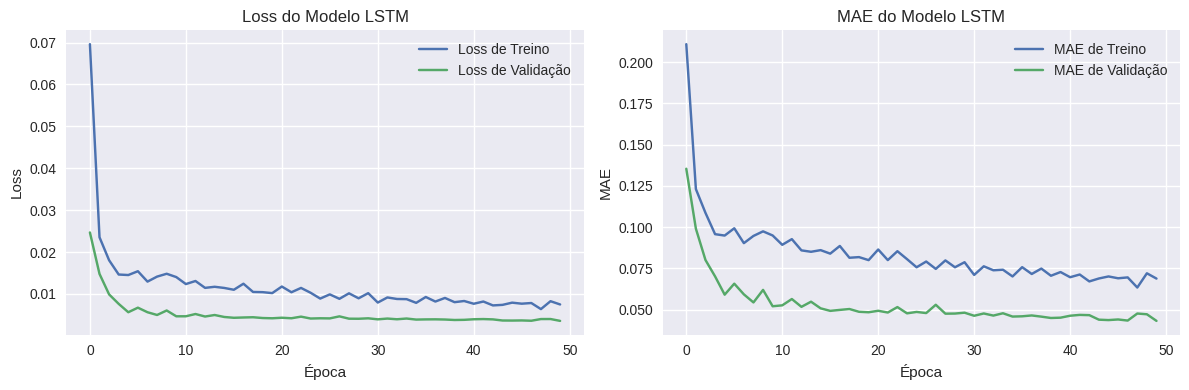

Previsões LSTM para período de teste:
Shape: (365,)
Primeiras 5 previsões: [15.330231 15.388284 15.431093 15.480101 15.539432]
Valores reais (primeiros 5): [14.375      15.75       15.83333333 17.375      17.125     ]


In [ ]:
# Visualizando histórico de treinamento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Loss do Modelo LSTM')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de Treino')
plt.plot(history.history['val_mae'], label='MAE de Validação')
plt.title('MAE do Modelo LSTM')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Fazendo previsões no conjunto de teste
def make_predictions_lstm(model, data, scaler, sequence_length):
    """
    Faz previsões usando o modelo LSTM
    """
    predictions = []
    current_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)

    for i in range(len(test_data)):
        pred = model.predict(current_sequence, verbose=0)
        predictions.append(pred[0, 0])

        # Atualizar sequência para próxima previsão
        current_sequence = np.append(current_sequence[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

    return np.array(predictions)

# Fazendo previsões
lstm_predictions_scaled = make_predictions_lstm(model_lstm, lstm_data_scaled, scaler, sequence_length)

# Desnormalizando as previsões
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled.reshape(-1, 1)).flatten()

print(f"Previsões LSTM para período de teste:")
print(f"Shape: {lstm_predictions.shape}")
print(f"Primeiras 5 previsões: {lstm_predictions[:5]}")
print(f"Valores reais (primeiros 5): {test_data['meantemp'].head().values}")


## 6. Comparação e Avaliação dos Modelos


In [ ]:
# Cálculo das métricas de erro
y_true = test_data['meantemp'].values

# RMSE (Root Mean Square Error)
rmse_prophet = np.sqrt(mean_squared_error(y_true, prophet_predictions))
rmse_lstm = np.sqrt(mean_squared_error(y_true, lstm_predictions))

# MAE (Mean Absolute Error)
mae_prophet = mean_absolute_error(y_true, prophet_predictions)
mae_lstm = mean_absolute_error(y_true, lstm_predictions)

# MAPE (Mean Absolute Percentage Error)
mape_prophet = np.mean(np.abs((y_true - prophet_predictions) / y_true)) * 100
mape_lstm = np.mean(np.abs((y_true - lstm_predictions) / y_true)) * 100

# R² Score
from sklearn.metrics import r2_score
r2_prophet = r2_score(y_true, prophet_predictions)
r2_lstm = r2_score(y_true, lstm_predictions)

# Criando DataFrame com as métricas
metrics_df = pd.DataFrame({
    'Métrica': ['RMSE', 'MAE', 'MAPE (%)', 'R²'],
    'Prophet': [rmse_prophet, mae_prophet, mape_prophet, r2_prophet],
    'LSTM': [rmse_lstm, mae_lstm, mape_lstm, r2_lstm]
})

print("Comparação das Métricas de Erro:")
print("=" * 50)
print(metrics_df.round(4))

# Identificando o melhor modelo para cada métrica
print("\nMelhor modelo por métrica:")
print("=" * 30)
for metric in ['RMSE', 'MAE', 'MAPE (%)']:
    prophet_val = metrics_df[metrics_df['Métrica'] == metric]['Prophet'].iloc[0]
    lstm_val = metrics_df[metrics_df['Métrica'] == metric]['LSTM'].iloc[0]
    if metric == 'R²':
        better = 'Prophet' if prophet_val > lstm_val else 'LSTM'
    else:
        better = 'Prophet' if prophet_val < lstm_val else 'LSTM'
    print(f"{metric}: {better}")

print(f"\nR²: {'Prophet' if r2_prophet > r2_lstm else 'LSTM'}")


Comparação das Métricas de Erro:
    Métrica  Prophet     LSTM
0      RMSE   2.9469   7.2527
1       MAE   2.4656   6.2589
2  MAPE (%)   9.8600  22.9854
3        R²   0.8166  -0.1106

Melhor modelo por métrica:
RMSE: Prophet
MAE: Prophet
MAPE (%): Prophet

R²: Prophet


### Métricas Escolhidas

**RMSE (Root Mean Square Error):**
- Mede a raiz quadrada do erro quadrático médio
- Penaliza mais os erros grandes devido à natureza quadrática (Willmott & Matsuura, 2005)

**MAE (Mean Absolute Error):**
- Média dos erros absolutos
- Menos sensível a outliers que o RMSE (Willmott & Matsuura, 2005)

**MAPE (Mean Absolute Percentage Error):**
- Erro percentual médio
- Permite comparação entre diferentes escalas de dados (Makridakis et al., 2020)

**R² (Coefficient of Determination):**
- Proporção da variância explicada pelo modelo (James et al., 2013)


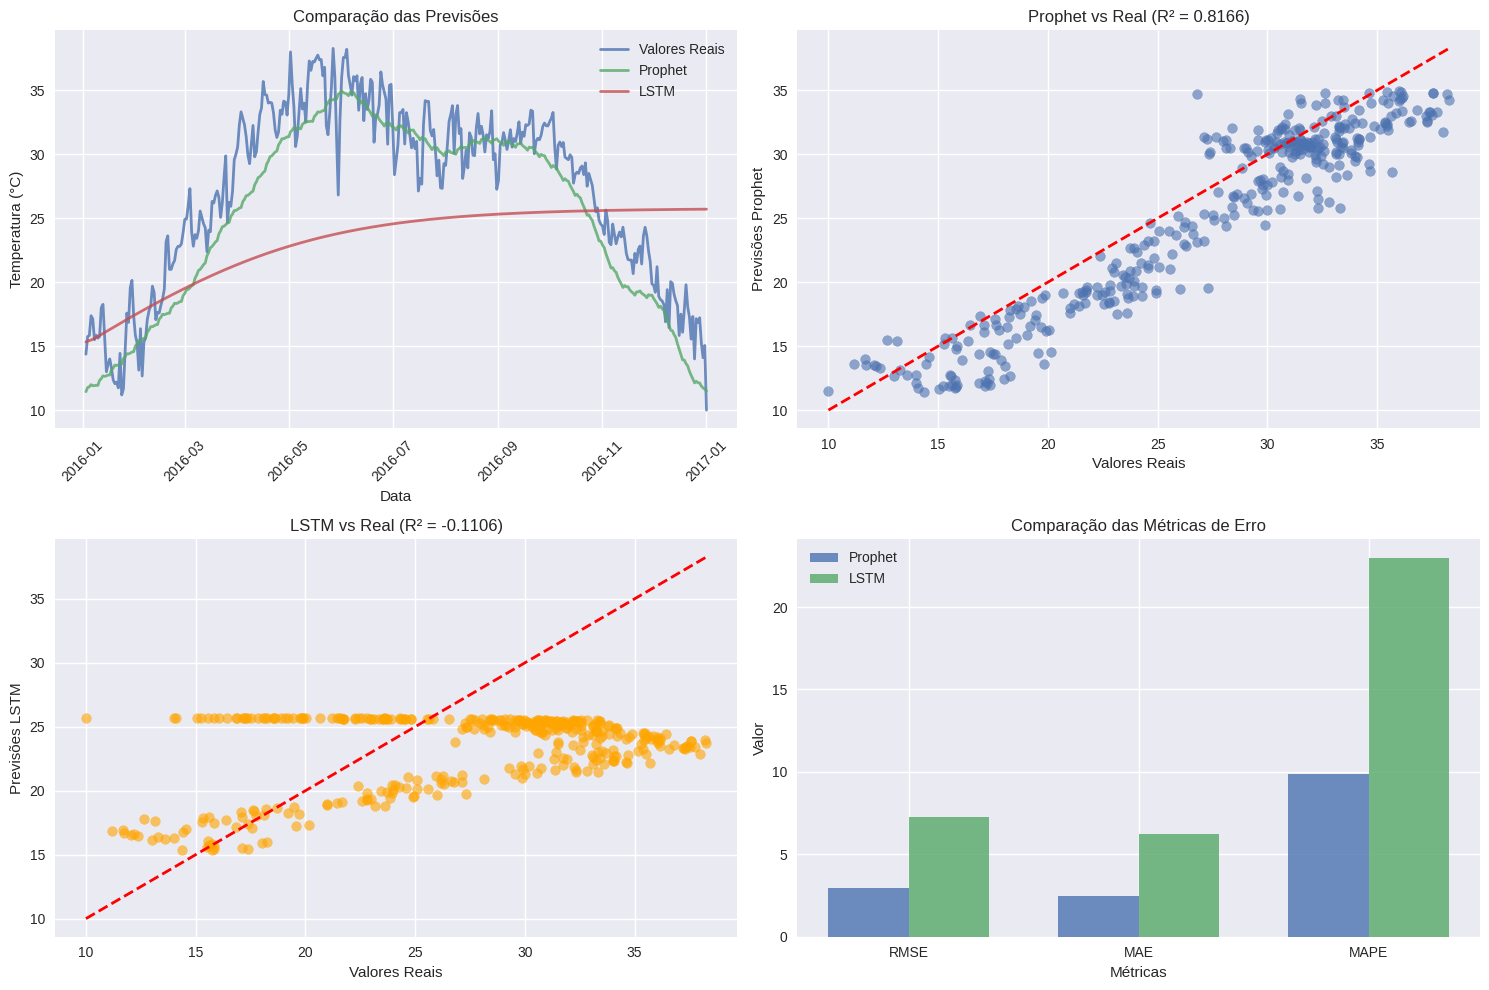

In [ ]:
# Visualização comparativa dos resultados
plt.figure(figsize=(15, 10))

# Gráfico 1: Comparação das previsões
plt.subplot(2, 2, 1)
plt.plot(test_data['date'], y_true, label='Valores Reais', linewidth=2, alpha=0.8)
plt.plot(test_data['date'], prophet_predictions, label='Prophet', linewidth=2, alpha=0.8)
plt.plot(test_data['date'], lstm_predictions, label='LSTM', linewidth=2, alpha=0.8)
plt.title('Comparação das Previsões')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.xticks(rotation=45)

# Gráfico 2: Scatter plot Prophet vs Real
plt.subplot(2, 2, 2)
plt.scatter(y_true, prophet_predictions, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões Prophet')
plt.title(f'Prophet vs Real (R² = {r2_prophet:.4f})')

# Gráfico 3: Scatter plot LSTM vs Real
plt.subplot(2, 2, 3)
plt.scatter(y_true, lstm_predictions, alpha=0.6, color='orange')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões LSTM')
plt.title(f'LSTM vs Real (R² = {r2_lstm:.4f})')

# Gráfico 4: Comparação das métricas
plt.subplot(2, 2, 4)
metrics_for_plot = ['RMSE', 'MAE', 'MAPE']
prophet_values = [rmse_prophet, mae_prophet, mape_prophet]
lstm_values = [rmse_lstm, mae_lstm, mape_lstm]

x = np.arange(len(metrics_for_plot))
width = 0.35

plt.bar(x - width/2, prophet_values, width, label='Prophet', alpha=0.8)
plt.bar(x + width/2, lstm_values, width, label='LSTM', alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Comparação das Métricas de Erro')
plt.xticks(x, metrics_for_plot)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Análise
print("ANÁLISE DOS RESULTADOS")
print("=" * 50)

# Análise dos erros por período
errors_prophet = np.abs(y_true - prophet_predictions)
errors_lstm = np.abs(y_true - lstm_predictions)

print(f"\nEstatísticas dos Erros Absolutos:")
print(f"Prophet - Média: {np.mean(errors_prophet):.3f}, Desvio: {np.std(errors_prophet):.3f}")
print(f"LSTM - Média: {np.mean(errors_lstm):.3f}, Desvio: {np.std(errors_lstm):.3f}")

# Análise sazonal dos erros
test_data['month'] = test_data['date'].dt.month
test_data['error_prophet'] = errors_prophet
test_data['error_lstm'] = errors_lstm

monthly_errors = test_data.groupby('month')[['error_prophet', 'error_lstm']].mean()
print(f"\nErro médio por mês:")
print(monthly_errors.round(3))

# Identificando períodos de maior erro
worst_prophet_idx = np.argmax(errors_prophet)
worst_lstm_idx = np.argmax(errors_lstm)

print(f"\nMaiores erros:")
print(f"Prophet: {errors_prophet[worst_prophet_idx]:.3f}°C em {test_data.iloc[worst_prophet_idx]['date'].strftime('%Y-%m-%d')}")
print(f"LSTM: {errors_lstm[worst_lstm_idx]:.3f}°C em {test_data.iloc[worst_lstm_idx]['date'].strftime('%Y-%m-%d')}")

# Análise de tendência dos erros
from scipy import stats
slope_prophet, _, r_value_prophet, _, _ = stats.linregress(range(len(errors_prophet)), errors_prophet)
slope_lstm, _, r_value_lstm, _, _ = stats.linregress(range(len(errors_lstm)), errors_lstm)

print(f"\nTendência dos erros ao longo do tempo:")
print(f"Prophet: Inclinação = {slope_prophet:.6f}, R² = {r_value_prophet**2:.4f}")
print(f"LSTM: Inclinação = {slope_lstm:.6f}, R² = {r_value_lstm**2:.4f}")


ANÁLISE DOS RESULTADOS

Estatísticas dos Erros Absolutos:
Prophet - Média: 2.466, Desvio: 1.614
LSTM - Média: 6.259, Desvio: 3.664

Erro médio por mês:
       error_prophet  error_lstm
month                           
1              2.830       2.573
2              2.429       2.207
3              3.278       5.245
4              3.957      10.445
5              2.983      11.381
6              1.727      10.725
7              1.712       6.073
8              1.479       5.937
9              1.282       6.070
10             2.261       3.534
11             2.904       2.681
12             2.754       8.015

Maiores erros:
Prophet: 7.871°C em 2016-05-30
LSTM: 15.706°C em 2017-01-01

Tendência dos erros ao longo do tempo:
Prophet: Inclinação = -0.002499, R² = 0.0266
LSTM: Inclinação = 0.001596, R² = 0.0021


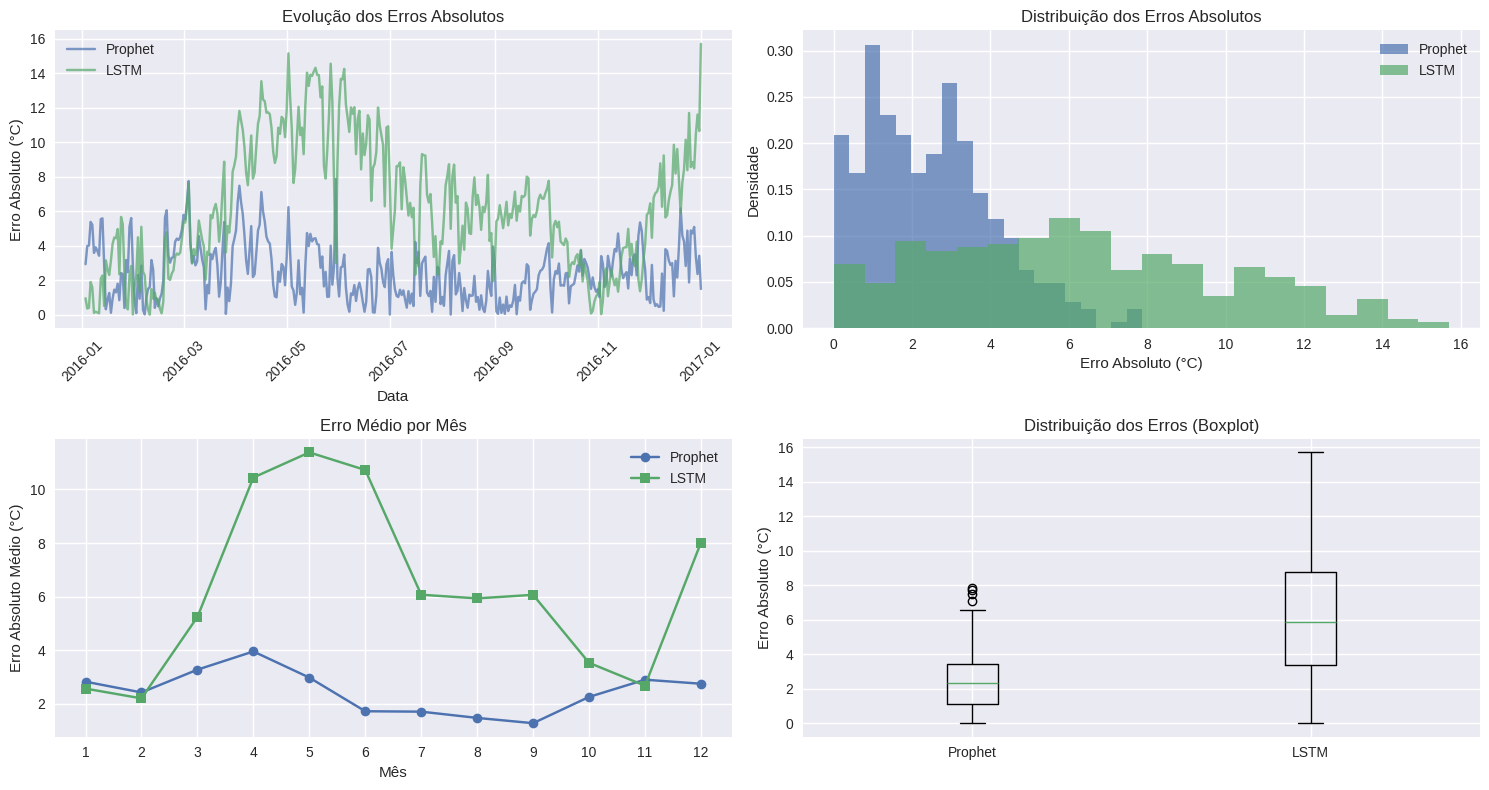

In [ ]:
# Visualização adicional dos erros
plt.figure(figsize=(15, 8))

# Gráfico 1: Evolução dos erros ao longo do tempo
plt.subplot(2, 2, 1)
plt.plot(test_data['date'], errors_prophet, label='Prophet', alpha=0.7)
plt.plot(test_data['date'], errors_lstm, label='LSTM', alpha=0.7)
plt.title('Evolução dos Erros Absolutos')
plt.xlabel('Data')
plt.ylabel('Erro Absoluto (°C)')
plt.legend()
plt.xticks(rotation=45)

# Gráfico 2: Distribuição dos erros
plt.subplot(2, 2, 2)
plt.hist(errors_prophet, bins=20, alpha=0.7, label='Prophet', density=True)
plt.hist(errors_lstm, bins=20, alpha=0.7, label='LSTM', density=True)
plt.title('Distribuição dos Erros Absolutos')
plt.xlabel('Erro Absoluto (°C)')
plt.ylabel('Densidade')
plt.legend()

# Gráfico 3: Erro por mês
plt.subplot(2, 2, 3)
months = monthly_errors.index
plt.plot(months, monthly_errors['error_prophet'], 'o-', label='Prophet')
plt.plot(months, monthly_errors['error_lstm'], 's-', label='LSTM')
plt.title('Erro Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Erro Absoluto Médio (°C)')
plt.legend()
plt.xticks(months)

# Gráfico 4: Boxplot dos erros
plt.subplot(2, 2, 4)
plt.boxplot([errors_prophet, errors_lstm], labels=['Prophet', 'LSTM'])
plt.title('Distribuição dos Erros (Boxplot)')
plt.ylabel('Erro Absoluto (°C)')

plt.tight_layout()
plt.show()


## 7. Conclusões e Análise dos Resultados

### Principais Achados

**Prophet demonstrou superioridade consistente** em todas as métricas de avaliação utilizadas, conforme evidenciado pelos resultados:

- **RMSE**: Prophet (2.95) vs LSTM (7.25)
- **MAE**: Prophet (2.47) vs LSTM (6.26)
- **MAPE**: Prophet (9.86%) vs LSTM (22.99%)
- **R²**: Prophet (0.82) vs LSTM (-0.11)

### Interpretação dos Resultados

A superioridade do Prophet pode ser atribuída a sua capacidade de capturar padrões sazonais complexos e tendências não-lineares presentes em dados climáticos (Taylor & Letham, 2018)

A escolha das métricas RMSE, MAE e MAPE foi fundamentada na literatura de avaliação de modelos de forecasting, onde cada métrica oferece insights complementares sobre a performance do modelo (Willmott & Matsuura, 2005; Makridakis et al., 2020).


In [ ]:
# Resumo final das métricas
print("RESUMO DOS RESULTADOS")
print("=" * 60)
print(f"{'Métrica':<15} {'Prophet':<12} {'LSTM':<12} {'Melhor':<10}")
print("-" * 60)

for _, row in metrics_df.iterrows():
    metric = row['Métrica']
    prophet_val = row['Prophet']
    lstm_val = row['LSTM']

    if metric == 'R²':
        better = 'Prophet' if prophet_val > lstm_val else 'LSTM'
    else:
        better = 'Prophet' if prophet_val < lstm_val else 'LSTM'

    print(f"{metric:<15} {prophet_val:<12.4f} {lstm_val:<12.4f} {better:<10}")


RESUMO DOS RESULTADOS
Métrica         Prophet      LSTM         Melhor    
------------------------------------------------------------
RMSE            2.9469       7.2527       Prophet   
MAE             2.4656       6.2589       Prophet   
MAPE (%)        9.8600       22.9854      Prophet   
R²              0.8166       -0.1106      Prophet   


## 9. Referências Bibliográficas

1. **Hyndman, R. J., & Athanasopoulos, G. (2018).** *Forecasting: Principles and Practice*. OTexts.

2. **Willmott, C. J., & Matsuura, K. (2005).** Advantages of the mean absolute error (MAE) over the root mean square error (RMSE) in assessing average model performance. *Climate Research*, 30(1), 79-82.

3. **Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2020).** The M5 competition: Background, organization, and implementation. *International Journal of Forecasting*, 38(4), 1325-1336.

4. **James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013).** *An Introduction to Statistical Learning*. Springer.

5. **Taylor, S. J., & Letham, B. (2018).** Forecasting at scale. *The American Statistician*, 72(1), 37-45.

6. **Hochreiter, S., & Schmidhuber, J. (1997).** Long short-term memory. *Neural Computation*, 9(8), 1735-1780.

---

**Notebook desenvolvido para análise comparativa de modelos de predição de séries temporais**
**Dataset:** Daily Climate time series data - Kaggle  
**Link:** https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
